# 0. Upload the raw Dataset and preprocess

In [1]:
%matplotlib notebook
import re
from utils.text_preprocessing import tokenize, stopwords, clean_text, preprocess
from parsers.russian_parser import Russian

[nltk_data] Downloading package punkt to /home/ekivo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ekivo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ekivo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ekivo/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [54]:
rus_data = Russian()
rus_data.parse_data()
len(rus_data.dataset)

No diagnosis in  74308
No diagnosis in  74319


4682

In [84]:
rus_data = clean_text(rus_data)
for r in rus_data.dataset:
    if r.label == 'норма':
        print(r.text)

Норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
изменения в плевре (сросшееся плеврально, наслоение, обызиствление) в шестом отделе норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
изменение скелета грудной клетки (костные мозоли, синостозы, добавочные ребра, остеофиты и выпот.загруд.) норма
Норма
Норма
Норма
Норма
состояние после операции в втором отделе,3 норма
Норма
изменение скелета грудной клетки (костные мозоли, синостозы, добавочные ребра, остеофиты и выпот.загруд.) норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
добавочная верхняя доля в первом отделе норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
сомнительные петрификаты в корнях норма
Норма
Норма
Норма
Норма
норма норма
Норма
Норма
Норма
Норма
Норма
Норма
Норма
норма норма
Норма
Норма
Норма
Норма
Норма
Норма
норма норма
Норма
Норма
Норма
Норма
Норма
добавочная верхняя доля в первом отделе норма
Норма
Норма
Норма
Норма
Норма
Н

In [60]:
rus_bad = rus_data.dataset
#for r in rus_data.dataset:
#    if r.label != 'норма':
#        rus_bad.append(r)
#    else:
#        print(r.text)

In [61]:
len(rus_bad)

4682

In [128]:
key_words = {
    "норма": ["норма"],
    "фиброз": ["фиброз"],
    "пневмосклероз": ["пневмосклероз"],
    "фиброторакс":["фиброторакс"],
    "липома":["липома"],
    "туберкулез":["туберкулез", "твс"],
    "петрификаты":["петрификаты"],
    "изменение скелета": ["изменение скелета"],
    "изменения в плевре": ["изменения в плевре"]
}

docs_with_ids = {
    "фиброз": ["resources/10.txt","resources/11.txt","resources/12.txt"],
    "пневмосклероз": ["resources/13.txt"],
}

defined_ids = {
    "фиброз": [],
    "пневмосклероз": []
}

for tag, docs in docs_with_ids.items():
    for doc in docs:
        with open(doc, 'r') as f:
            for line in f.readlines():
                defined_ids[tag].append(int(line))

In [129]:
def get_tags(reports):
    tags = []
    for i in range(len(reports)):
        report_tags = []
        if reports[i].label == 'норма':
            report_tags.append('норма')
            
        for tag, ids in defined_ids.items():
            if int(reports[i].id) in ids:
                report_tags.append(tag)
                #print(tag, reports[i].id)
        for tag, key_w in key_words.items():
            query = "|".join(key_w)
            pattern = re.compile(r'\W('+ query +')\W')
            found = False
            for match in re.findall(pattern, reports[i].text):
                found = True
            if found and not tag in report_tags:
                report_tags.append(tag)
        tags.append(report_tags)
    return tags

In [130]:
import random
     
def generate_color():
    r = int(random.random() * 256)
    g = int(random.random() * 256)
    b = int(random.random() * 256)
    
    return [r,g,b]

In [131]:
def tag_list_to_color(tags):
    colors = []
    undefined_color = 'grey'
    used_colors = []
    color_binding = {'норма':'LightGreen'}
    
    for tag in tags:
        if len(tag) == 0:
            colors.append(undefined_color)
        else:
            code = ' '.join(tag)
            if not code in color_binding:
                color = generate_color()
                while color in used_colors:
                    color = generate_color()
                color_binding[code] = [color[0]/256,color[1]/256,color[2]/256 ]
                used_colors.append(color)
            colors.append(color_binding[code])
    return colors, color_binding

# 1.

In [132]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [133]:
report_tags, color_def = tag_list_to_color(get_tags(rus_bad))

common_texts = [preprocess(report.text, lemmatize=True, without_stop_words=True, lang='russian') for report in rus_bad]

In [69]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(common_texts)]

In [70]:
model = Doc2Vec(
    documents,     # collection of texts
    vector_size=15, # output vector size
    window=5,      # maximum distance between the target word and its neighboring word
    min_count=1,   # minimal number of 
    workers=4      # in parallel
)
model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model.save("d2v_2.model")
model = Doc2Vec.load("d2v_2.model")

vec = model.infer_vector(["system", "response"])
print(vec)

[ 0.01403593  0.01935844  0.01898636 -0.03036985 -0.03190379  0.00401139
  0.01018823 -0.00370556  0.01715999 -0.0103646  -0.02081775 -0.01114981
  0.02752718  0.01771004  0.02552229]


# 2.

In [71]:
import numpy as np
from sklearn.manifold import TSNE

In [72]:
vectors = [model.infer_vector(doc.words) for doc in documents]
X = np.array(vectors)
X_embedded = TSNE(n_components=2).fit_transform(X)
X_embedded.shape

(4682, 2)

In [73]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D

<IPython.core.display.Javascript object>


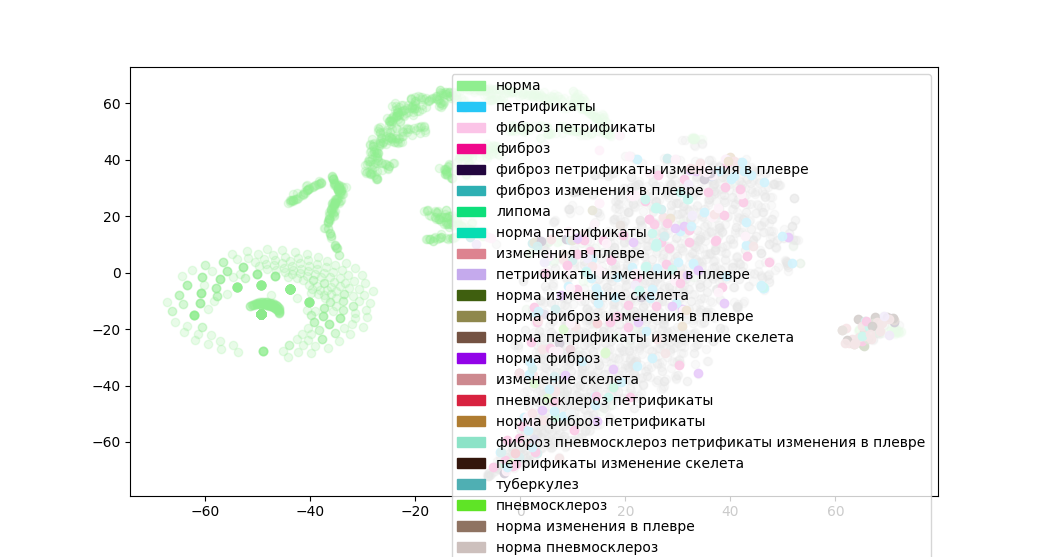

In [134]:
plt.figure(figsize=(20,17))
patches = [mpatches.Patch(color=c, label=l) for l,c in color_def.items()]
for point,c in zip(X_embedded, report_tags):
    if c == "grey" or c == color_def['норма']:
        alpha = 0.2
        plt.plot(point[0],point[1], 'o', color=c ,  alpha=alpha)
    else:
        continue

for point,c in zip(X_embedded, report_tags):
    if c == "grey" or c == color_def['норма']:
        continue
    else:
        alpha = 0.9
        plt.plot(point[0],point[1], 'o', color=c,  alpha=alpha)
    
#plt.plot(X_embedded, 'o')
plt.legend(handles=patches)
plt.show()

In [138]:
for i in range(len(X_embedded)):
    x, y = X_embedded[i]
    if abs(x+6) < 22 and y>35 :
        print(documents[i].words)

['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']
['норма']


# 3

In [51]:
X_embedded_3d = TSNE(n_components=3).fit_transform(X)
X_embedded_3d.shape

(2338, 3)

<IPython.core.display.Javascript object>


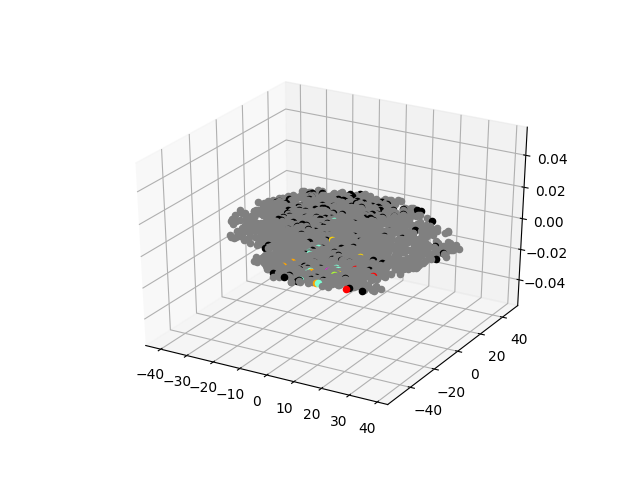

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for point,c in zip(X_embedded_3d, report_tags):
    if c == "grey":
        alpha = 0.2
    else:
        alpha = 0.9
    ax.scatter(point[0], point[1], color=c )
plt.show()